# Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re 

In [3]:
#загружаем файл с данными
try:
    citys = pd.read_csv('forFBpost.csv', sep=';')
except:
    print('Файл не найден')

# Анализ данных

In [4]:
citys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30250 entries, 0 to 30249
Data columns (total 6 columns):
Город              30250 non-null object
year               30250 non-null int64
fact               3250 non-null float64
Модель             30250 non-null float64
Нижняя граница     30250 non-null float64
Верхняя граница    30250 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [5]:
#Таблица справочник - наименования столбцов
columns=['name','desc']
data = [
    ['city','Город'],
    ['year','year'],
    ['fact','fact'],
    ['model','Модель'],
    ['min','Нижняя граница'],
    ['max','Верхняя граница'],          
]

TOP = 3

columns_names = pd.DataFrame(columns=columns, data=data)


def rename_cols(data,col_desc) -> pd.DataFrame:
    """
    rename columns by list of names and descriptions
    """
    for i, row in col_desc.iterrows():
        try:
            print(f"{row['desc']} -> {row['name']}")
            data = data.rename(columns={row['desc']:row['name']})
        except: print(f"column {row['desc']} not exist")
    return data

citys = rename_cols(citys, columns_names)
citys = citys.fillna(0)

# по какойто причине в таюлице есть повторяющиеся данные для одинаковых гороров и годов
display(citys[citys.duplicated(subset=['city','year'], keep=False)].sort_values(by=['city','year']))
citys = citys.drop_duplicates(subset=['city','year'])

Город -> city
year -> year
fact -> fact
Модель -> model
Нижняя граница -> min
Верхняя граница -> max


,city,year,fact,model,min,max
15125,Кировск,2000,0.0,28100.0,27900.0,28300.0
16940,Кировск,2000,0.0,33600.0,33300.0,33800.0
15126,Кировск,2001,0.0,28000.0,27800.0,28200.0
16941,Кировск,2001,0.0,33400.0,33200.0,33700.0
15127,Кировск,2002,0.0,27900.0,27600.0,28100.0
...,...,...,...,...,...,...
27948,Краснослободск,2118,0.0,2500.0,2300.0,2600.0
4354,Краснослободск,2119,0.0,16400.0,16100.0,16800.0
27949,Краснослободск,2119,0.0,2500.0,2300.0,2600.0
4355,Краснослободск,2120,0.0,16400.0,16100.0,16800.0


In [6]:
def city_selec (start_year_fact, end_year_fact, end_year_model):
    result = (
        citys.loc[citys['year'] == start_year_fact][['city','fact']]
        .merge(citys.loc[citys['year'] == end_year_fact][['city','fact']],
                     how='left',  on='city', 
                     suffixes=['_'+str(start_year_fact),'_'+str(end_year_fact)])
    
        .merge(citys.loc[citys['year'] == end_year_model][['city','model']], on='city', 
                     how='left', suffixes=['_'+str(end_year_model),''])    
    )

    result = result.rename(columns={'model':'model_'+str(end_year_model)})    
    return result


citys_08_20_40 = city_selec(2008, 2020, 2040)


citys_08_20_40['fact_dinamik'] = citys_08_20_40['fact_2020']/citys_08_20_40['fact_2008']
citys_08_20_40['model_dinamik'] = citys_08_20_40['model_2040']/citys_08_20_40['fact_2020']

In [7]:
def show_graph(data, top_city):        
    for id, сitys in top_city.iterrows():        
        fact = (
                        data.query(f"city == \"{сitys['city']}\" and year >= 2008 and year <= 2020")
                        .pivot_table(index='city',columns='year', values='fact')
        )
        model = (
                        data.query(f"city == \"{сitys['city']}\" and year >= 2008 and year <= 2040")
                        .pivot_table(index='city',columns='year', values='model')
        )
        fig = plt.figure(figsize=(20, 3)) #создание фигуры для рисования графиков 
        ax = fig.add_subplot(111) #создание осей координат для рисования графиков         
        fact.loc[сitys['city']].plot(#linestyle=line_v, color=color_v, 
                         ax=ax, grid=True, rot=45, alpha=0.7, label='label', title=сitys['city'])  
        model.loc[сitys['city']].plot(#linestyle=line_v, color=color_v, 
                         ax=ax, grid=True, rot=45, alpha=0.7, label='label')  

'Топ 3 городов за период с 2008 по 2020'

,city,fact_2008,fact_2020,fact_dinamik
0,Магас,4431.0,8295.0,1.872038
1,Анапа,141105.0,199851.0,1.416328
2,Михайловка,63007.0,86792.0,1.377498


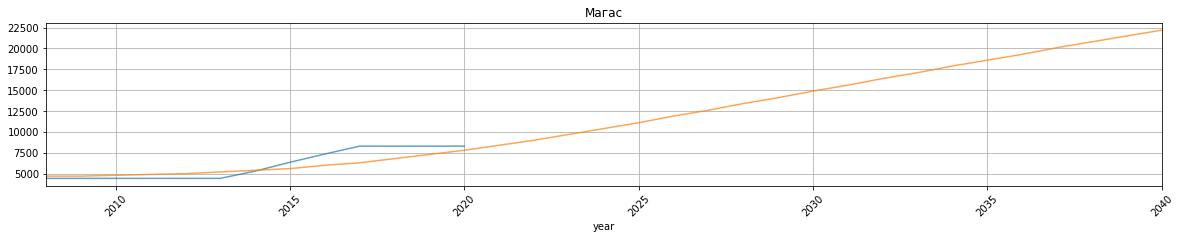

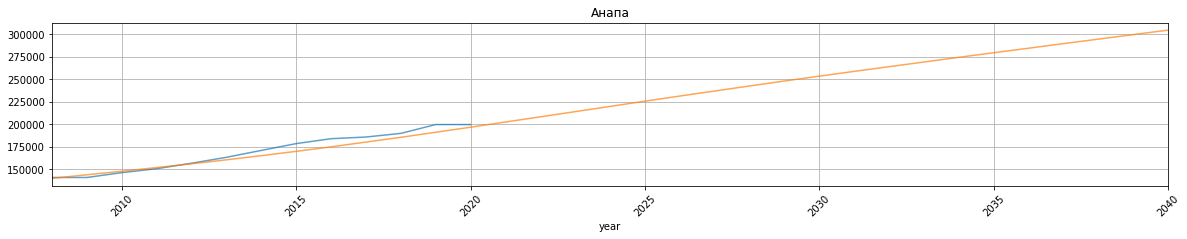

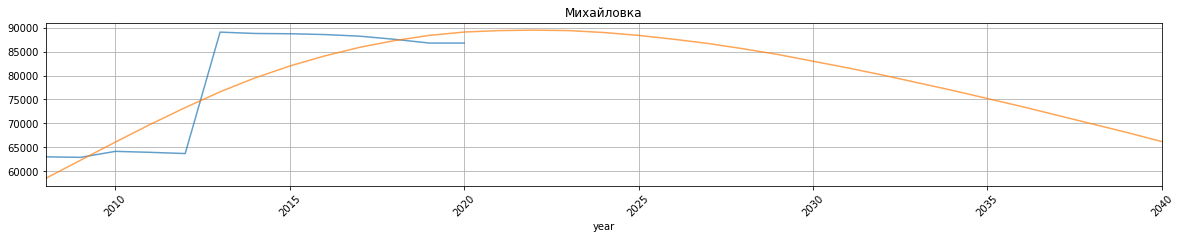

In [8]:
display(f'Топ {TOP} городов за период с 2008 по 2020')
top_10_citys_fact = citys_08_20_40.sort_values(by='fact_dinamik', ascending=False).head(TOP)
display(top_10_citys_fact[['city','fact_2008','fact_2020','fact_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_fact)

'Топ 3 худьших городов за период с 2008 по 2020'

,city,fact_2008,fact_2020,fact_dinamik
0,Воркута,111983.0,72773.0,0.649858
1,Инта,39088.0,26559.0,0.679467
2,Александровск-Сахалинский,15041.0,10768.0,0.715910


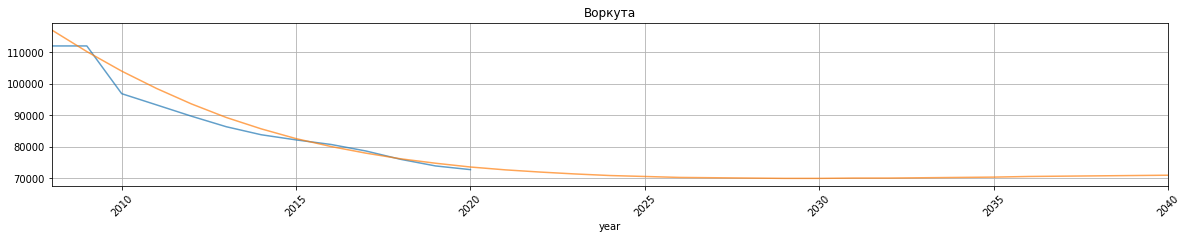

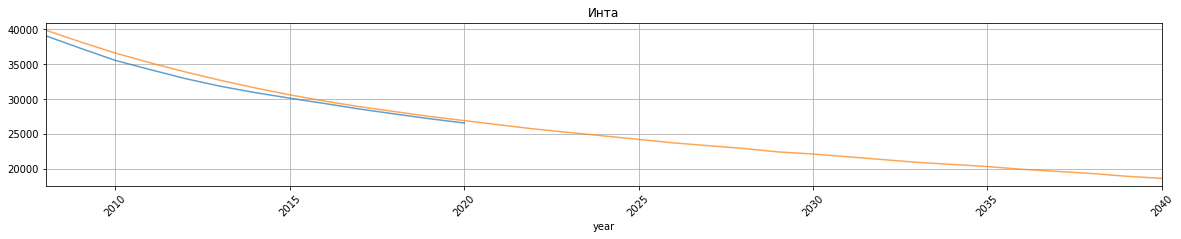

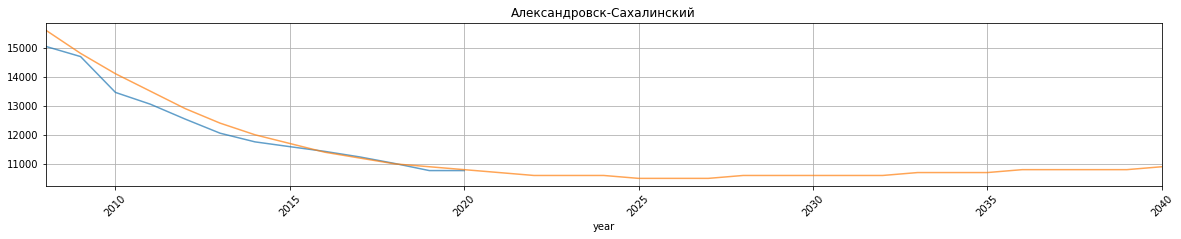

In [9]:
display(f'Топ {TOP} худьших городов за период с 2008 по 2020')
bottom_10_citys_fact = citys_08_20_40.sort_values(by='fact_dinamik', ascending=True).head(TOP)
display(bottom_10_citys_fact[['city','fact_2008','fact_2020','fact_dinamik']].reset_index(drop=True))
show_graph(citys, bottom_10_citys_fact)

'Топ 3 городов по прогнозам модели к 2040'

,city,fact_2020,model_2040,model_dinamik
0,Гудермес,56521.0,169900.0,3.005962
1,Магас,8295.0,22200.0,2.676311
2,Коломна,183980.0,404400.0,2.198065


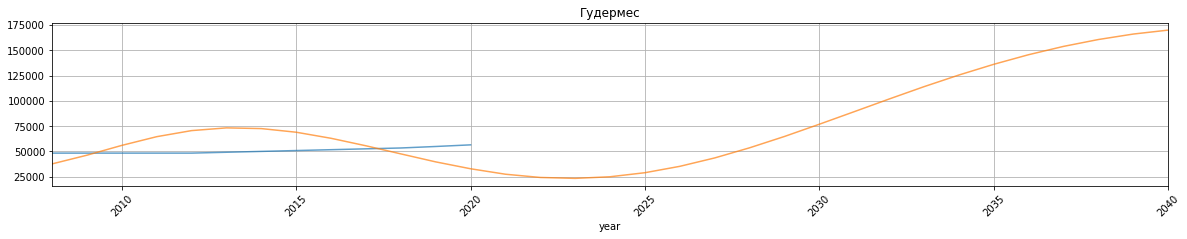

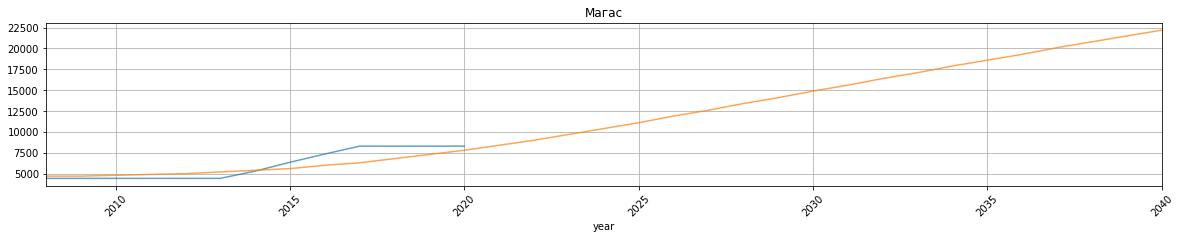

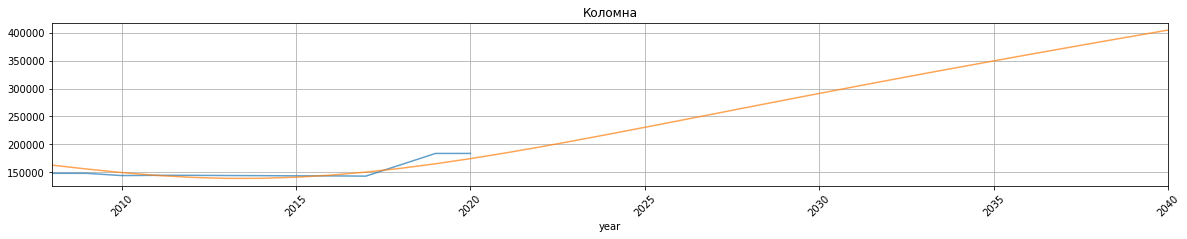

In [10]:
display(f'Топ {TOP} городов по прогнозам модели к 2040')
top_10_citys_model = citys_08_20_40.sort_values(by='model_dinamik', ascending=False).head(TOP)
display(top_10_citys_model[['city','fact_2020','model_2040','model_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_model)

'Топ 3 худьших городов по прогнозам модели к 2040'

,city,fact_2020,model_2040,model_dinamik
0,Гудермес,56521.0,169900.0,3.005962
1,Магас,8295.0,22200.0,2.676311
2,Коломна,183980.0,404400.0,2.198065


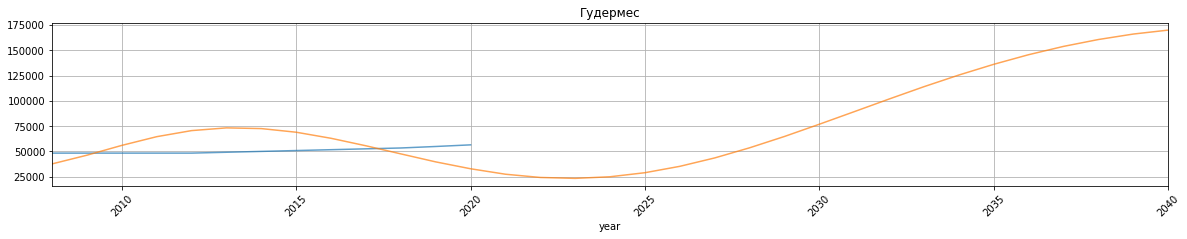

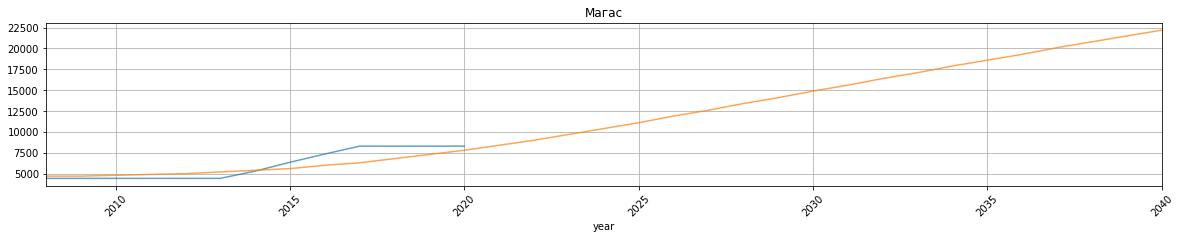

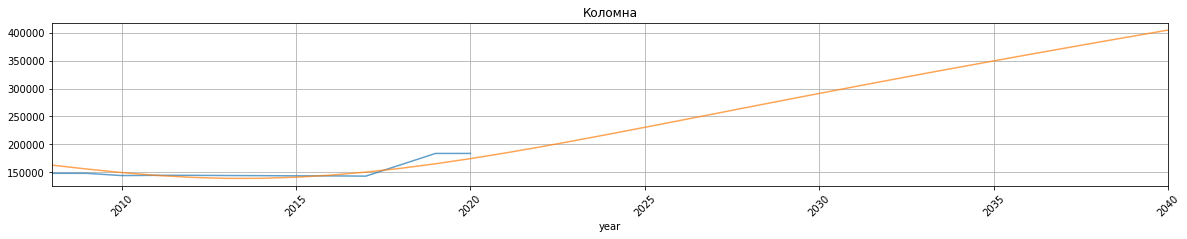

In [11]:
display(f'Топ {TOP} худьших городов по прогнозам модели к 2040')
top_10_citys_model = citys_08_20_40.sort_values(by='model_dinamik', ascending=False).head(TOP)
display(top_10_citys_model[['city','fact_2020','model_2040','model_dinamik']].reset_index(drop=True))
show_graph(citys, top_10_citys_model)

# Выводы:
Не все города, население которых выросло с 2008 по 2020 продолжают расти по численности населения.
Некоторые городов из топ 3 по росту на данный момент имеют отрицательную динамику.

Так же можно сделать другие отчеты по другим временым отрезкам.